# import

In [1]:
import torch
import pandas as pd
from glob import glob
import os

from torch.utils.data.dataset import Dataset
import cv2
from PIL import Image
import PIL
import numpy as np
from albumentations.pytorch import transforms
import albumentations as A
import timm
import matplotlib.pyplot as plt
import torchsummary
from tqdm import tqdm
import logging

from models.vggnet import VGGNet
from models.googlenet import GoogleNet
from models.resnet import ResNet
from models.densenet import DenseNet
from models.xception import Xception
from models.vit import ViT
from models.swin_transformer import SwinTransformer

[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.


In [2]:
# read
base_path = '../../datasets/mnist'
num = glob(f'{base_path}/training/*')
# for i, n in enumerate(num):
#     print(n)


imgs = list()
labels = list()

for direc in glob(f'{base_path}/training/*'):
    for p in glob(f'{direc}/*'):
        num = p.split('/')[-2]
        imgs.append(p)
        labels.append(num)

In [3]:
df = pd.DataFrame()
df['img_path'] = imgs
df['label'] = labels

In [4]:
class Mnist(Dataset):
    def __init__(self, df, transforms=None):
        self.data = df
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data.iloc[idx]
        img = np.array(Image.open(path))
        img = np.expand_dims(img, -1)
        img = np.concatenate([img, img, img], axis=-1)
        img = self.transforms(image=img) if self.transforms else img
        label = int(label)
        
        return img, label 

In [5]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=0.5, std=0.5),
        transforms.ToTensorV2()
    ]
)

In [6]:
ds = Mnist(df, transform)
loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


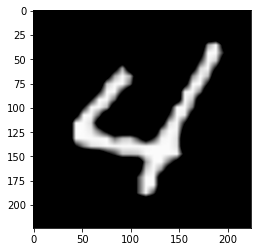

In [7]:
img, label = ds.__getitem__(1)
plt.imshow(np.transpose(img['image'], (1, 2, 0)), cmap='gray')

In [8]:
model = SwinTransformer(num_classes=10)
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=2e-05, weight_decay=1e-8)

/home/hebb/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
for epoch in range(10):
    import os
    if os.path.exists('train.log'):
        os.remove('train.log')
    logger = logging.Logger('train')
    handler = logging.FileHandler('train.log')
    logger.addHandler(handler)

    model.train()
    model.to('cuda:0')

    ep_loss = 0
    ep_acc = 0
    step = 0
    for data in tqdm(loader):
        step += 1

        img, label = data
        img = img['image'].type(torch.float32)
        img = img.to('cuda:0')
        label = torch.tensor(label, dtype=torch.float32).to('cuda:0')
        pred = model(img)
        pred = pred.type(torch.float32)
        pred.requires_grad_(True)

        loss = criterion(pred, label.type(torch.int64))
        optim.zero_grad()
        loss.backward()
        optim.step()

        ep_loss += loss
        
        m = pred.detach().cpu().max(1, keepdim=True)[1]
        acc = m.eq(label.cpu().data.view_as(m)).sum()
        ep_acc += acc

        # if step == 8:
        #     optim.step()
        #     optim.zero_grad()
        #     step = 0
        logger.info(f'acc: {acc / len(data)},  loss: {loss}')

    print('loss: ', ep_loss / len(loader.dataset))
    print('acc: ', ep_acc / len(loader.dataset))
        

  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_786/3851365311.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).to('cuda:0')
100%|██████████| 938/938 [09:37<00:00,  1.63it/s]


loss:  tensor(0.0327, device='cuda:0', grad_fn=<DivBackward0>)
acc:  tensor(0.2368)


 52%|█████▏    | 491/938 [04:54<04:30,  1.65it/s]

In [ ]:
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 224, 224]               6
              ReLU-2          [-1, 3, 224, 224]               0
            Conv2d-3         [-1, 32, 111, 111]             864
       BatchNorm2d-4         [-1, 32, 111, 111]              64
              ReLU-5         [-1, 32, 111, 111]               0
            Conv2d-6         [-1, 64, 109, 109]          18,432
       BatchNorm2d-7         [-1, 64, 109, 109]             128
              ReLU-8         [-1, 64, 109, 109]               0
            Conv2d-9        [-1, 128, 109, 109]           8,192
      BatchNorm2d-10        [-1, 128, 109, 109]             256
             ReLU-11        [-1, 128, 109, 109]               0
           Conv2d-12        [-1, 128, 109, 109]           1,152
      BatchNorm2d-13        [-1, 128, 109, 109]             256
             ReLU-14        [-1, 128, 1